In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

In [7]:
# Download latest version
current_dir = os.getcwd()
path = kagglehub.dataset_download("irkaal/foodcom-recipes-and-reviews")

print("Path to dataset files:", path)

100%|██████████| 723M/723M [01:06<00:00, 11.5MB/s] 

Extracting files...


Path to dataset files: C:\Users\spadr\.cache\kagglehub\datasets\irkaal\foodcom-recipes-and-reviews\versions\2


In [8]:
pd.set_option('display.max_columns', None)

In [2]:
dfRec = pd.read_csv('..\\data\\recipes.csv')
dfRev = pd.read_csv('..\\data\\reviews.csv')

In [ ]:
dfRev.head(25)
# print(dfRev['Review'].head(10).tolist())

In [ ]:
print(dfRev['Review'].head(25).tolist())

In [ ]:
dfRec.head(10)

In [ ]:
# print(dfRec['Images'].head(10).tolist())
print(dfRec[dfRec['RecipeId'] == 992])

# Data Exploration

## Recipe Dataset

In [ ]:
dfRec.info()
dfRec.describe()

In [ ]:
recipe_category_counts = dfRec['RecipeCategory'].value_counts()
top_10_counts = recipe_category_counts.head(25) # Select only the top 25 categories
other_count = recipe_category_counts.iloc[25:].sum()
top_10_with_other = pd.concat([top_10_counts, pd.Series({'Other':other_count})])

plt.figure(figsize=(10, 6))
plt.pie(top_10_with_other, labels=top_10_with_other.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Recipe Categories')
plt.show()

### Data Cleaning

In [ ]:
dfRec.drop(columns=['Images'], inplace=True)
dfRec.drop(columns=['RecipeYield'], inplace=True) # Too many nulls

# Deal with null values:
dfRec['CookTime'].fillna(0, inplace=True) # NaN means no cooking required
dfRec['ReviewCount'].fillna(0, inplace=True) # NaN means no reviews
dfRec['AggregatedRating'].fillna(2.5, inplace=True) # Use a neutral value even though median is 5.0 and mean 4.6 since we have no indication of quality
dfRec['RecipeServings'].fillna(dfRec['RecipeServings'].median(), inplace=True)
dfRec['Description'].fillna('', inplace=True) # Put empty description
dfRec['RecipeCategory'].fillna(dfRec['Name'], inplace=True) # Substitute category with recipe name
dfRec['Keywords'].fillna(dfRec['RecipeIngredientParts'], inplace=True) # Substitute with ingredients, any better ideas?
dfRec['RecipeIngredientQuantities'].fillna('c("0")',inplace=True) # There are only 3 missing

dfRec.info()

In [ ]:
dfRec.describe()

### Dataset Splitting and Scaling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

num_feature_columns = [
    'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
    'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent',
    'ProteinContent', 'RecipeServings'
]

train_recipe_data, test_recipe_data = train_test_split(dfRec, test_size=0.2, random_state=42)
recipe_scaler = StandardScaler()

train_recipe_data[num_feature_columns] = recipe_scaler.fit_transform(train_recipe_data[num_feature_columns])
test_recipe_data[num_feature_columns] = recipe_scaler.transform(test_recipe_data[num_feature_columns]) # Use fit from trainig data to prevent data leakage

## Review Dataset

In [7]:
dfRev.info()
dfRev.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401982 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


,ReviewId,RecipeId,AuthorId,Rating
count,1.401982e+06,1.401982e+06,1.401982e+06,1.401982e+06
mean,8.179739e+05,1.526412e+05,1.558638e+08,4.407951e+00
std,5.280821e+05,1.301112e+05,5.305111e+08,1.272012e+00
min,2.000000e+00,3.800000e+01,1.533000e+03,0.000000e+00
25%,3.743862e+05,4.703875e+04,1.336800e+05,4.000000e+00
50%,7.717805e+05,1.093270e+05,3.305450e+05,5.000000e+00
75%,1.204126e+06,2.318768e+05,8.183590e+05,5.000000e+00
max,2.090347e+06,5.412980e+05,2.002902e+09,5.000000e+00


### Data Cleaning

In [16]:
dfRev['Review'].fillna('', inplace=True) # Put empty description for now
dfRev.drop(columns=['DateSubmitted'], inplace=True) # Only keep DateModified
dfRev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ReviewId      1401982 non-null  int64 
 1   RecipeId      1401982 non-null  int64 
 2   AuthorId      1401982 non-null  int64 
 3   AuthorName    1401982 non-null  object
 4   Rating        1401982 non-null  int64 
 5   Review        1401982 non-null  object
 6   DateModified  1401982 non-null  object
dtypes: int64(4), object(3)
memory usage: 74.9+ MB


<Axes: ylabel='Frequency'>

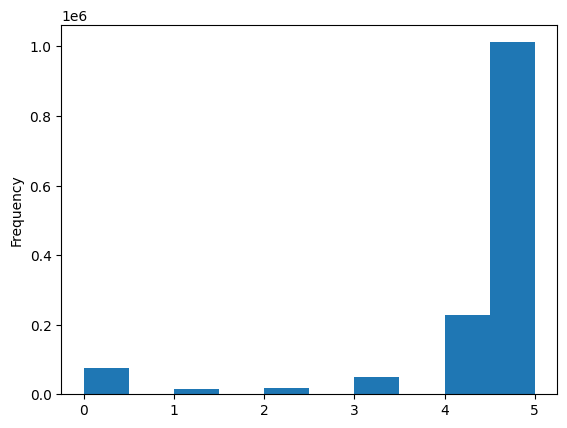

In [9]:
dfRev['Rating'].plot(kind='hist')

In [10]:
train_review_data, test_review_data = train_test_split(dfRev, test_size=0.2, random_state=42)
review_scaler = StandardScaler() # tried QuantileTransformer and PowerTransformer but the data is still very skewed


train_review_data['Rating'] = review_scaler.fit_transform(train_review_data['Rating'].values.reshape(-1, 1))
test_review_data['Rating'] = review_scaler.transform(test_review_data['Rating'].values.reshape(-1, 1)) # Use fit from trainig data to prevent data leakage

# User and Recipe Embeddings

In [11]:
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

batch_size = 1000
reviews = train_review_data['Review'].tolist()

all_embeddings = []

for i in tqdm(range(0, len(reviews), batch_size), desc="Encoding reviews"):
    batch = reviews[i:i+batch_size]
    batch_embeddings = model.encode(batch)
    all_embeddings.append(batch_embeddings)

review_embeddings = np.vstack(all_embeddings)
print(review_embeddings.shape)

Encoding reviews:   0%|          | 0/1122 [00:00<?, ?it/s]

(1121585, 384)


In [12]:
print(review_embeddings[0])

[ 3.78684364e-02  2.16917396e-02 -1.14754308e-02 -4.97727795e-03
 -4.24552374e-02 -1.06500713e-02 -7.31702521e-02  2.44287285e-03
  4.92023770e-03 -3.58772501e-02  5.68518322e-03  1.93594806e-02
  6.02437891e-02 -5.78651354e-02 -3.12981382e-02 -2.64686886e-02
  4.79288585e-02 -1.07014976e-01 -5.01321927e-02  1.83421094e-02
 -4.49898876e-02 -3.55539508e-02  4.58991304e-02 -1.28357895e-02
 -4.70138714e-02 -6.52479306e-02  2.74737664e-02  2.24872623e-02
 -2.79741623e-02 -9.83463787e-03  1.34782139e-02  3.17507498e-02
  6.59011081e-02 -2.07547639e-02  3.44033986e-02 -4.75265598e-03
 -4.15503280e-03  1.84805579e-02 -3.16265523e-02  1.49884988e-02
 -1.14750369e-02  5.45996949e-02  6.34672642e-02  1.29321134e-02
  2.54576956e-03  3.93404588e-02 -2.97465362e-02  1.12655889e-02
  2.09916066e-02  2.00143233e-02  3.91658768e-03 -2.09554210e-02
  1.87429935e-02 -6.07767664e-02  2.75233164e-02  7.09867617e-03
 -1.85914889e-01 -6.16307035e-02 -4.09503765e-02 -5.71611151e-02
  3.21405120e-02  6.38788

In [13]:
train_review_data.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
1369526,2055003,107786,2001757945,maureenmiller16,0.465609,My first time making spare ribs for the family...,2018-05-29T03:29:40Z,2018-05-29T03:29:40Z
145399,155996,13680,88099,Nimz_,-0.320427,My daughter and I really enjoyed this with our...,2005-02-24T18:00:09Z,2005-02-24T18:00:09Z
498190,540194,2189,685371,Iss4796,0.465609,This recipe is great! It was simple to make an...,2007-12-24T08:34:26Z,2007-12-24T08:34:26Z
96618,104617,89186,141139,tatumis,0.465609,Uber-yummy. thanks so much for passing the re...,2004-05-24T23:31:56Z,2004-05-24T23:31:56Z
1199756,1377986,497871,178427,CJAY8248,0.465609,Terrific! This is one sauce I will be making o...,2013-04-03T20:58:09Z,2013-04-03T20:58:09Z


In [19]:
train_review_data['Review'] = list(review_embeddings)
train_review_data.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
1369526,2055003,107786,2001757945,maureenmiller16,0.465609,"[0.037868436, 0.02169174, -0.011475431, -0.004...",2018-05-29T03:29:40Z,2018-05-29T03:29:40Z
145399,155996,13680,88099,Nimz_,-0.320427,"[-0.018034594, -0.02860534, -0.032772142, 0.04...",2005-02-24T18:00:09Z,2005-02-24T18:00:09Z
498190,540194,2189,685371,Iss4796,0.465609,"[-0.06688794, -0.06380604, -0.007883271, 0.010...",2007-12-24T08:34:26Z,2007-12-24T08:34:26Z
96618,104617,89186,141139,tatumis,0.465609,"[-0.03430109, -0.012518336, 0.022372436, -0.02...",2004-05-24T23:31:56Z,2004-05-24T23:31:56Z
1199756,1377986,497871,178427,CJAY8248,0.465609,"[-0.10111904, -0.088520795, -0.02396931, 0.020...",2013-04-03T20:58:09Z,2013-04-03T20:58:09Z


In [22]:
train_review_data.drop(columns=['DateSubmitted'], inplace=True)

In [23]:
train_review_data.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateModified
1369526,2055003,107786,2001757945,maureenmiller16,0.465609,"[0.037868436, 0.02169174, -0.011475431, -0.004...",2018-05-29T03:29:40Z
145399,155996,13680,88099,Nimz_,-0.320427,"[-0.018034594, -0.02860534, -0.032772142, 0.04...",2005-02-24T18:00:09Z
498190,540194,2189,685371,Iss4796,0.465609,"[-0.06688794, -0.06380604, -0.007883271, 0.010...",2007-12-24T08:34:26Z
96618,104617,89186,141139,tatumis,0.465609,"[-0.03430109, -0.012518336, 0.022372436, -0.02...",2004-05-24T23:31:56Z
1199756,1377986,497871,178427,CJAY8248,0.465609,"[-0.10111904, -0.088520795, -0.02396931, 0.020...",2013-04-03T20:58:09Z


In [24]:
train_review_data.to_csv('train_review_data_with_embeddings.csv', index=False)

KeyboardInterrupt: 

In [25]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

2024-12-04 02:18:36,335 INFO: Initializing external client
2024-12-04 02:18:36,336 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-04 02:18:45,104 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1193139


In [34]:
# Get or create the 'Reviews' feature group
reviews_fg = fs.get_or_create_feature_group(
    name="reviews",
    version=1,
    description="Reviews for recipe recommender system.",
    primary_key=['reviewid']
)

In [37]:
print(train_review_data.shape)

(1121585, 7)


In [35]:
# Insert data into feature group
reviews_fg.insert(train_review_data)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1193139/fs/1181782/fg/1378790


Uploading Dataframe: 100.00% |██████████| Rows 1121585/1121585 | Elapsed Time: 13:18 | Remaining Time: 00:00


Launching job: reviews_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1193139/jobs/named/reviews_1_offline_fg_materialization/executions


(Job('reviews_1_offline_fg_materialization', 'SPARK'), None)

In [36]:
feature_descriptions = [
    {"name": "reviewid", "description": "Unique identifier for each review"},
    {"name": "recipeid", "description": "Identifier for the recipe being reviewed"},
    {"name": "authorid", "description": "Identifier for the author of the review"},
    {"name": "authorname", "description": "Name of the author of the review"},
    {"name": "rating", "description": "Rating given by the author to the recipe (usually 1-5)"},
    {"name": "review", "description": "Numerical representation of the review text (embedding vector from SentenceTransformer)"},
    {"name": "datemodified", "description": "The date when the review was last modified"}
]

for desc in feature_descriptions: 
    reviews_fg.update_feature_description(desc["name"], desc["description"])

# Model Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoTowerRecommendationSystem(nn.Module):
    def __init__(self,
                 recipe_vocab_sizes, review_vocab_sizes,
                 embedding_dim, numerical_dims):
        super(TwoTowerRecommendationSystem, self).__init__()

        # Embeddings for Recipe Tower
        self.recipe_embeddings = nn.ModuleDict({
            key: nn.Embedding(vocab_size, embedding_dim)
            for key, vocab_size in recipe_vocab_sizes.items()
        })

        # Embeddings for Review Tower
        self.review_embeddings = nn.ModuleDict({
            key: nn.Embedding(vocab_size, embedding_dim)
            for key, vocab_size in review_vocab_sizes.items()
        })

        # Recipe Tower Network
        recipe_input_dim = len(recipe_vocab_sizes) * embedding_dim + numerical_dims['recipe']
        self.recipe_fc = nn.Sequential(
            nn.Linear(recipe_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Review Tower Network
        review_input_dim = len(review_vocab_sizes) * embedding_dim + numerical_dims['review']
        self.review_fc = nn.Sequential(
            nn.Linear(review_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, recipe_inputs, review_inputs):
        # Recipe Tower
        recipe_embeds = [
            self.recipe_embeddings[key](value)
            for key, value in recipe_inputs['categorical'].items()
        ]
        recipe_embeds = torch.cat(recipe_embeds, dim=-1)
        recipe_combined = torch.cat([recipe_embeds, recipe_inputs['numerical']], dim=-1)
        recipe_output = self.recipe_fc(recipe_combined)

        # Review Tower
        review_embeds = [
            self.review_embeddings[key](value)
            for key, value in review_inputs['categorical'].items()
        ]
        review_embeds = torch.cat(review_embeds, dim=-1)
        review_combined = torch.cat([review_embeds, review_inputs['numerical']], dim=-1)
        review_output = self.review_fc(review_combined)

        # Calculate similarity (dot product or cosine similarity)
        similarity = F.cosine_similarity(recipe_output, review_output, dim=-1)

        return similarity

# Training